In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import probplot
import sklearn
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, FunctionTransformer
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, RepeatedKFold, learning_curve, GridSearchCV
from sklearn.metrics import root_mean_squared_error, r2_score, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectFromModel
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
import xgboost as XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

pd.set_option('display.max_columns', None)

In [ ]:
# Print versions
print("NumPy version:", np.__version__)
print("Pandas version:", pd.__version__)
print("Scikit-learn version:", sklearn.__version__)
print("XGBoost version:", XGBRegressor.__version__)

# LOAD DATA

In [ ]:
df = pd.read_csv('data_for_training.csv')
df.head()

,Ky_QT_adjust,Tuoi,GIOI_TINH,So_Ngay_DTri_adjust,MA_LYDO_VVIEN,MA_LOAI_KCB,regions,HI,insurance,hang,tuyen,checkComorbidities,comorbidities,loaiBienChung,soBienChung_cat,diemBienChung_cat,nhomTuoi,log_TongChi
0,2018,83,1,1,1,1,Đồng Bằng Sông Hồng,Ngân sách Nhà nước đóng,100%,Không có hạng,Quận/Huyện,1,E78,MML,2,2,≥60,11.003765
1,2018,83,1,1,1,1,Đồng Bằng Sông Hồng,Ngân sách Nhà nước đóng,100%,Không có hạng,Quận/Huyện,1,E78,MML,2,2,≥60,11.762594
2,2018,83,1,1,1,1,Đồng Bằng Sông Hồng,Ngân sách Nhà nước đóng,100%,Không có hạng,Quận/Huyện,1,E78,MML,2,2,≥60,12.323055
3,2019,85,1,1,1,1,Đồng Bằng Sông Hồng,Ngân sách Nhà nước đóng,100%,1,Trung ương,0,Benh khac,Khong,0,0,≥60,10.518673
4,2020,81,2,12,1,3,Đồng Bằng Sông Hồng,Ngân sách Nhà nước đóng,100%,1,Trung ương,1,I10,Khong,0,0,≥60,17.140549


In [ ]:
# Change data types
df[['GIOI_TINH','MA_LYDO_VVIEN','MA_LOAI_KCB','checkComorbidities']] = df[['GIOI_TINH','MA_LYDO_VVIEN','MA_LOAI_KCB','checkComorbidities']].astype(object)

# Change col names
df.rename(columns={'Tuoi':'Tuổi', 'So_Ngay_DTri_adjust':'Số ngày điều trị'}, inplace=True)

# Reverse log transformation
df["log_TongChi"] = np.log(df["T_TONGCHI"])

# Check distribution of target variable

Original target variable

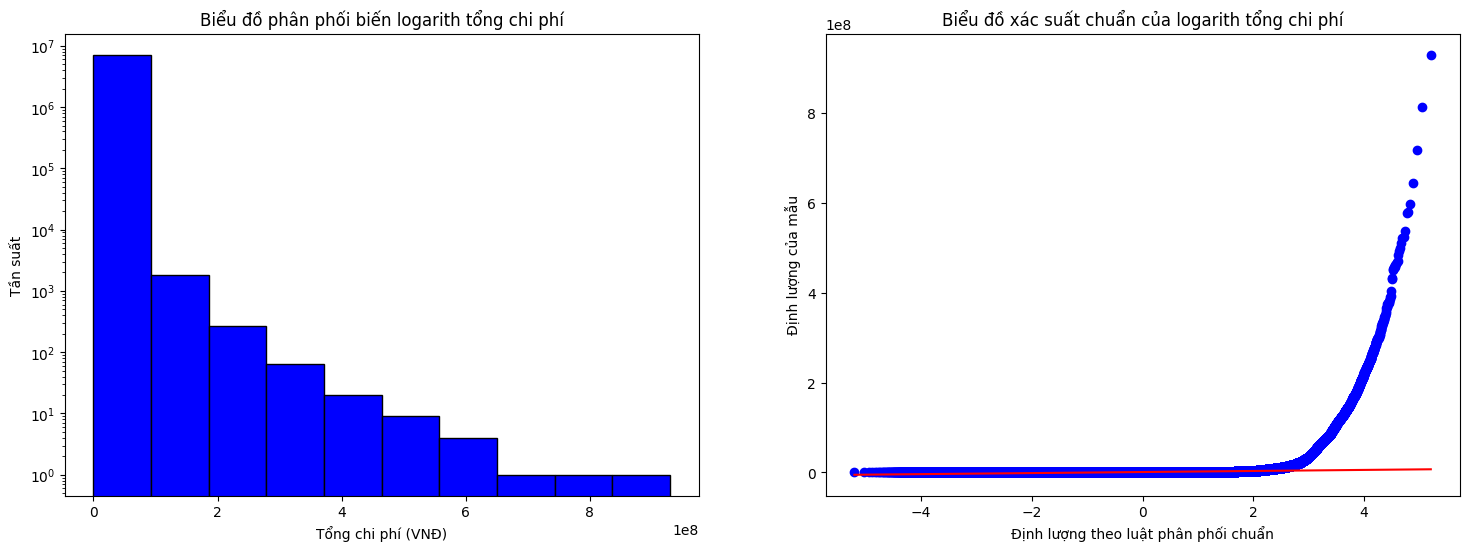

In [ ]:
plt.figure(figsize = (18,6))
plt.subplot(1,2,1)
plt.hist(df['T_TONGCHI'], bins=10, log=True, color='blue', edgecolor='black')
plt.title('Biểu đồ phân phối biến logarith tổng chi phí')
plt.xlabel('Tổng chi phí (VNĐ)')
plt.ylabel('Tần suất')
plt.subplot(1,2,2)
probplot(df['T_TONGCHI'], dist='norm', plot=plt)
plt.title('Biểu đồ xác suất chuẩn của logarith tổng chi phí')
plt.xlabel('Định lượng theo luật phân phối chuẩn')
plt.ylabel('Định lượng của mẫu')
plt.savefig('target_dist_log.png')

Log transformation target variable

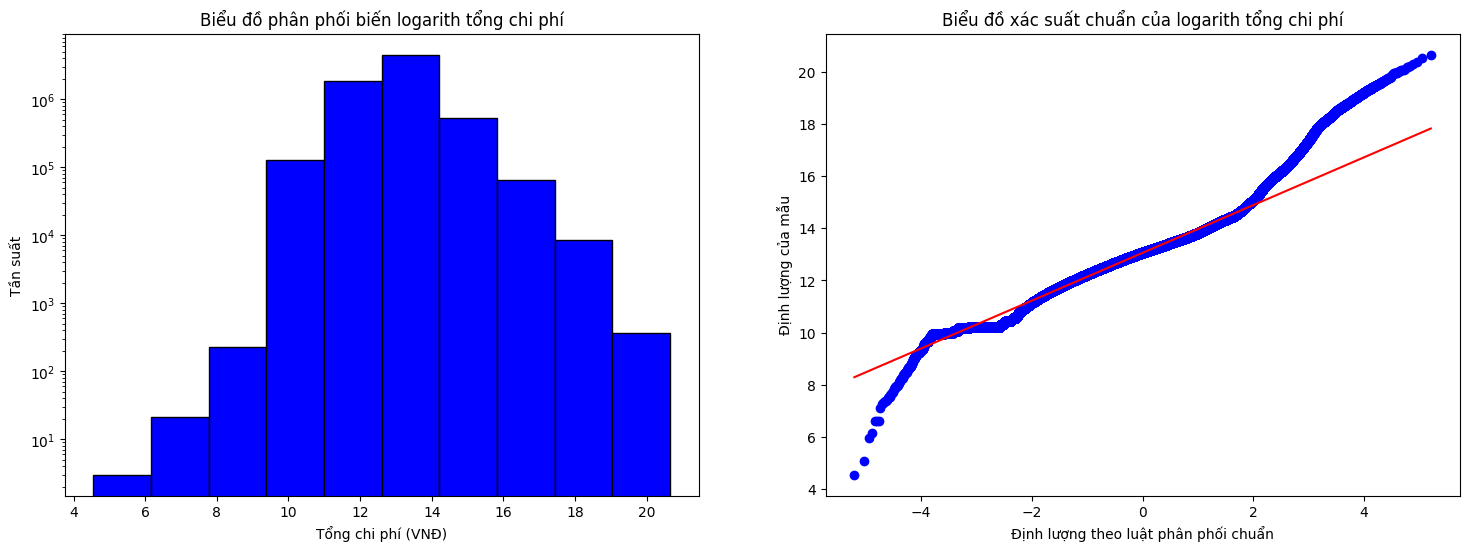

In [ ]:
plt.figure(figsize = (18,6))
plt.subplot(1,2,1)
plt.hist(df['log_TongChi'], bins=10, log=True, color='blue', edgecolor='black')
plt.title('Biểu đồ phân phối biến logarith tổng chi phí')
plt.xlabel('Tổng chi phí (VNĐ)')
plt.ylabel('Tần suất')
plt.subplot(1,2,2)
probplot(df['log_TongChi'], dist='norm', plot=plt)
plt.title('Biểu đồ xác suất chuẩn của logarith tổng chi phí')
plt.xlabel('Định lượng theo luật phân phối chuẩn')
plt.ylabel('Định lượng của mẫu')
plt.savefig('target_dist.png')

# EDA

In [ ]:
# Define groups of variables
categorical_features = ['GIOI_TINH', 'MA_LYDO_VVIEN', 'MA_LOAI_KCB', 'regions', 'HI',
       'insurance', 'hang', 'tuyen', 'comorbidities',
        'loaiBienChung', 'nhomTuoi']
numerical_features = ['Tuổi', 'Số ngày điều trị']   
other_features = ['Ky_QT_adjust','checkComorbidities', 'soBienChung_cat', 'diemBienChung_cat']     # maintained columns

C:\Users\ncdhuy\AppData\Local\Temp\ipykernel_4136\275108019.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  x = df.groupby(['Ky_QT_adjust'], group_keys=False).apply(lambda x: x.sample(n=500000))


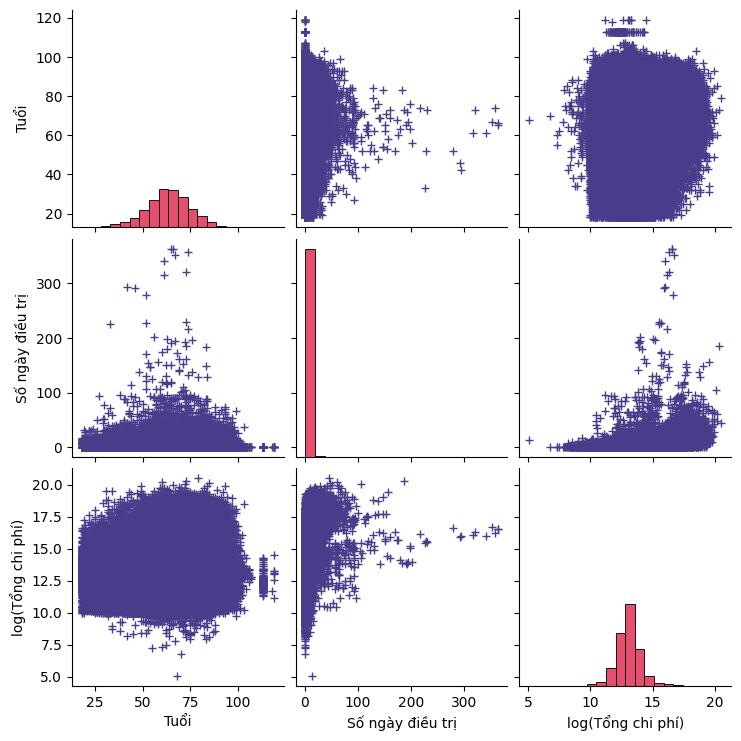

In [ ]:
x = df.groupby(['Ky_QT_adjust'], group_keys=False).apply(lambda x: x.sample(n=500000))
sns.pairplot(
    x[['Tuổi','Số ngày điều trị','log_TongChi']],
    plot_kws=dict(marker="+", linewidth=1, color='darkslateblue'),
    diag_kws=dict(fill=True, color='crimson',bins=20),
)
plt.show()

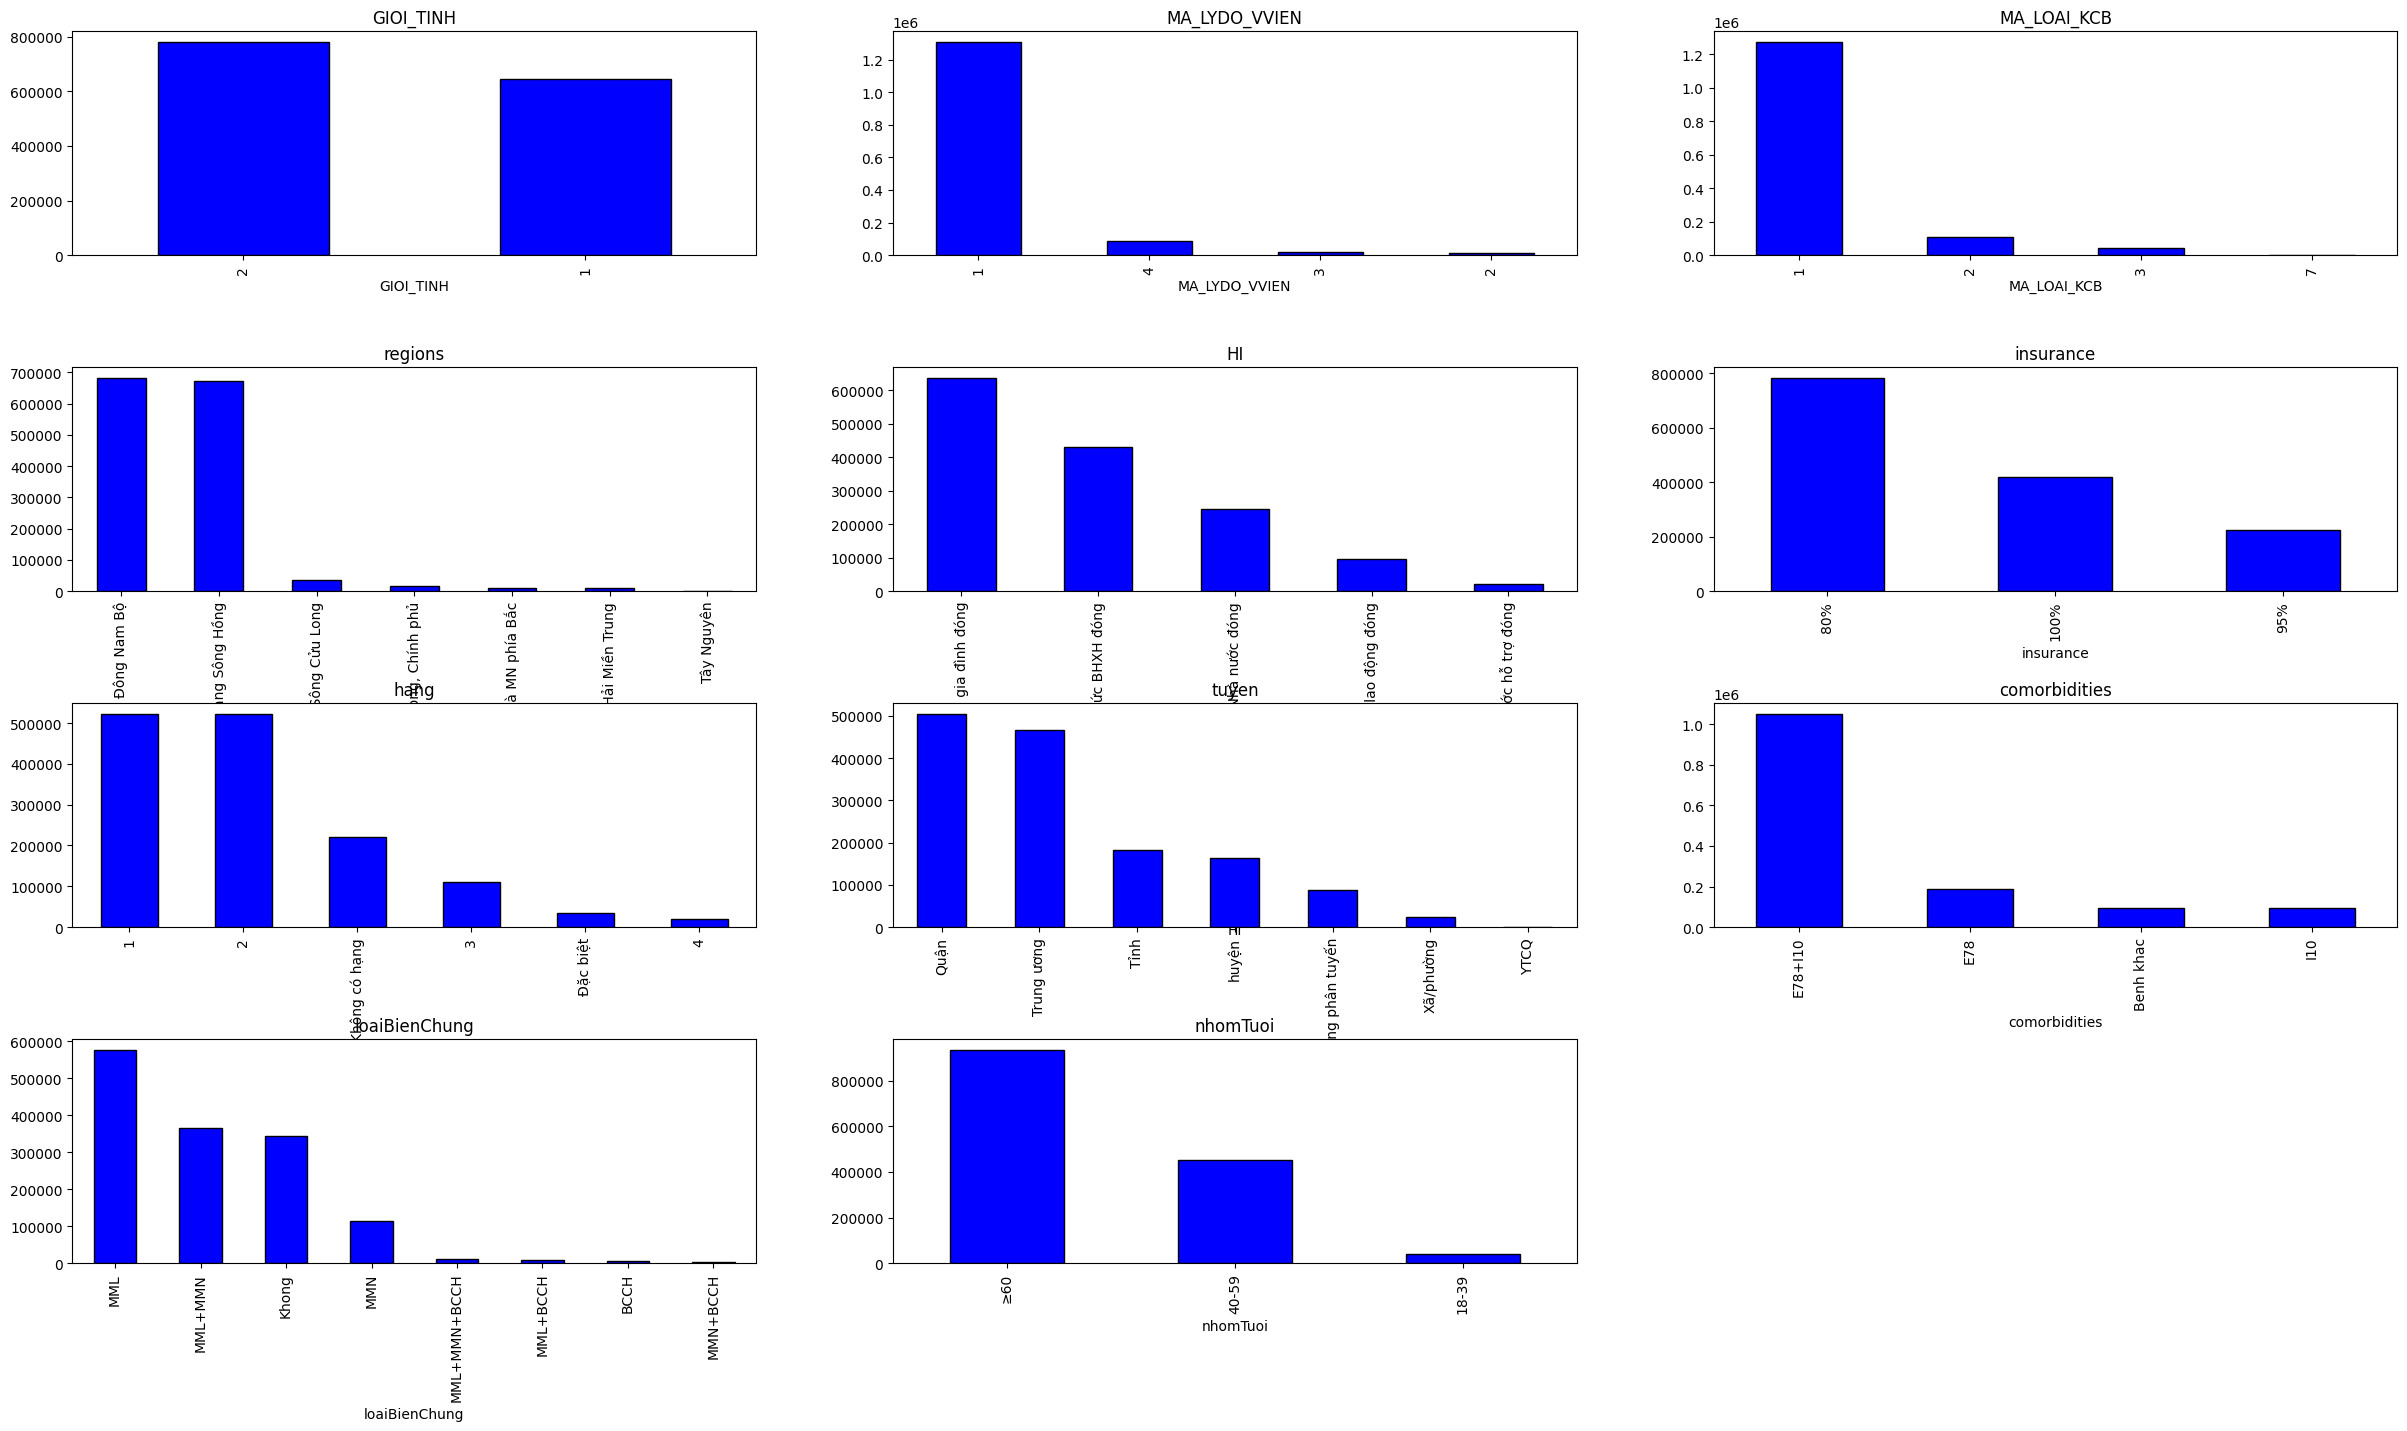

In [ ]:
def distribution_cate(df, cate_cols, row = 4, col = 3, figsize = (20, 5)):
  plt.figure(figsize = figsize)
  plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.5)    
  for i in range(1, len(cate_cols)+1, 1):
      plt.subplot(row, col, i)
      df[cate_cols[i-1]].value_counts().plot.bar(color='blue', edgecolor='black')
      plt.title(cate_cols[i-1])

distribution_cate(df, categorical_features, row = 4, col = 3, figsize = (30, 16))

# Settings for Model Training

In [ ]:
import random
random.seed(42)

In [ ]:
# df_sample = df.sample(frac=1, random_state=42, )
X = df.drop('log_TongChi', axis=1)
y = df['log_TongChi']

# Define preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('other', 'passthrough', other_features)
    ]
)

# Test performance on subsample

In [ ]:
# Define the selected models
models = {
    'Linear Regression': LinearRegression(),
    # 'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42)
}

# Define different sampling fractions
fractions = [0.1, 0.2, 0.5, 0.8]

# Store results
results = {model_name: [] for model_name in models.keys()}

for frac in fractions:
    X_sample, _, y_sample, _ = train_test_split(X, y, train_size=frac, random_state=42)
    
    for model_name, model in models.items():
        # Cross-validation on the sample dataset
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor), 
            ('regressor', model)
        ])
        sample_scores = cross_validate(pipeline, X_sample, y_sample, cv=3, scoring='r2', return_train_score=True)
        
        # Store the mean R² score
        results[model_name].append(sample_scores['test_score'].mean())

# Convert results to a DataFrame for better visualization
results_df = pd.DataFrame(results, index=fractions)

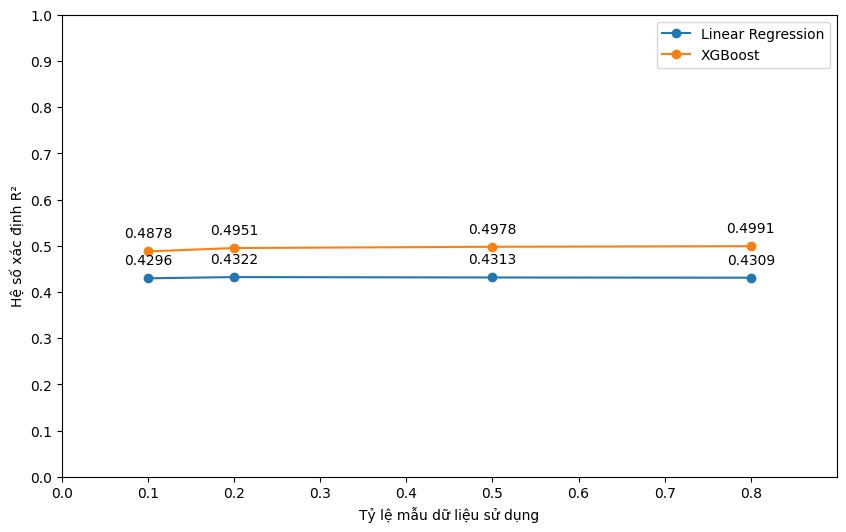

In [ ]:
# Plotting
plt.figure(figsize=(10, 6))
for model_name, scores in results.items():
    plt.plot(fractions, scores, marker='o', label=model_name)
    for frac, score in zip(results_df.index, scores):
        plt.annotate(f'{score:.4f}', (frac, score), textcoords="offset points", xytext=(0,10), ha='center')
plt.ylim((0,1))
plt.xlim((0.2,0.9))
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, 0.9, step=0.1))
plt.xlabel('Tỷ lệ mẫu dữ liệu sử dụng')
plt.ylabel('Hệ số xác định R²')
# plt.title('Model performance with different sampling fractions')
plt.legend(loc='upper right')
plt.grid(False)
plt.savefig('sample_r2.jpeg')
plt.show()

# Model Training

In [ ]:
# Define metrics
scoring = {
    'r2': make_scorer(r2_score),
    'rmse': make_scorer(root_mean_squared_error)
}

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.1, random_state=42)

## LinearRegression

In [ ]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Perform cross-validation
cv_results = cross_validate(
    pipeline, X_train, y_train, cv=3, scoring=scoring, return_train_score=True
)

# Access the results
print("R2 scores:", cv_results['test_r2'])
print("RMSE scores:", cv_results['test_rmse'])
print("Mean R2:", cv_results['test_r2'].mean())
print("Mean RMSE:", cv_results['test_rmse'].mean())

R2 scores: [0.43042569 0.43112789 0.43115256]
RMSE scores: [0.69936795 0.69814615 0.7008887]
Mean R2: 0.4309020441386097
Mean RMSE: 0.6994676012511439


## Ridge Regression

In [ ]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge())
])

# Define the parameter grid
param_grid = {
    'regressor__alpha': [0.1, 0.5, 1, 10],
}

grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='r2', verbose=1)
grid_search.fit(X_train, y_train)

# 5. Evaluate the model
best_model = grid_search.best_estimator_
print(grid_search.best_params_)
y_pred = best_model.predict(X_test)
print(f'R2 Score: {r2_score(y_test, y_pred)}')
print(f'RMSE: {root_mean_squared_error(y_test, y_pred)}')

Fitting 3 folds for each of 4 candidates, totalling 12 fits
R2 Score: 0.4284057504387593
RMSE: 0.703293700134983


## Lasso Regression

In [6]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Lasso(random_state=42))
])

# Define the parameter grid
param_grid = {
    'regressor__alpha': [0.001],
}

grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='r2', verbose=1)
grid_search.fit(X_train, y_train)

# 5. Evaluate the model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_pred = best_model.predict(X_test)
print(grid_search.best_params_)
print(f'R2 Score: {r2_score(y_test, y_pred)}')
print(f'RMSE: {root_mean_squared_error(y_test, y_pred)}')

Fitting 3 folds for each of 1 candidates, totalling 3 fits
R2 Score: 0.42743956827908647
RMSE: 0.7038878479245165


## Elasticnet Regression

In [7]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', ElasticNet(random_state=42))
])

# Define the parameter grid
param_grid = {
    'regressor__alpha': [0.005, 0.01, 0.03],
    'regressor__l1_ratio': [0.1, 0.5]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='r2', verbose=1)
grid_search.fit(X_train, y_train)

# 5. Evaluate the model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print(grid_search.best_params_)
print(f'R2 Score: {r2_score(y_test, y_pred)}')
print(f'RMSE: {root_mean_squared_error(y_test, y_pred)}')

Fitting 3 folds for each of 6 candidates, totalling 18 fits
{'regressor__alpha': 0.005, 'regressor__l1_ratio': 0.1}
R2 Score: 0.4243691951132539
RMSE: 0.7057726347607527


## Random Forest

In [ ]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(max_depth=6))
])

# Perform cross-validation
cv_results = cross_validate(
    pipeline, X_train, y_train, cv=3, scoring=scoring, return_train_score=True
)

# Access the results
print("R2 scores:", cv_results['test_r2'])
print("RMSE scores:", cv_results['test_rmse'])
print("Mean R2:", cv_results['test_r2'].mean())
print("Mean RMSE:", cv_results['test_rmse'].mean())

R2 scores: [0.44972276 0.4506137  0.45006683]
RMSE scores: [0.68741864 0.68608502 0.68913786]
Mean R2: 0.45013443179343354
Mean RMSE: 0.6875471742715323


## LinearSVR

In [ ]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearSVR())
])

# Define the parameter grid
param_grid = {
    'regressor__C': [1],
    'regressor__epsilon': [0.1]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=2, scoring='r2', verbose=1)
grid_search.fit(X_train, y_train)

# 5. Evaluate the model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print(grid_search.best_params_)
print(f'R2 Score: {r2_score(y_test, y_pred)}')
print(f'RMSE: {root_mean_squared_error(y_test, y_pred)}')

Fitting 2 folds for each of 1 candidates, totalling 2 fits
R2 Score: 0.367003665999723
RMSE: 0.7439736734433813


## MLP Regression

In [ ]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', MLPRegressor(hidden_layer_sizes=(50,100,50), alpha=0.0001, learning_rate="adaptive"))
])

# Perform cross-validation
cv_results = cross_validate(
    pipeline, X_train, y_train, cv=3, scoring=scoring, return_train_score=True
)

# Access the results
print("R2 scores:", cv_results['test_r2'])
print("RMSE scores:", cv_results['test_rmse'])
print("Mean R2:", cv_results['test_r2'].mean())
print("Mean RMSE:", cv_results['test_rmse'].mean())

R2 scores: [0.46575561 0.44607117 0.46664013]
RMSE scores: [0.67904983 0.6902079  0.67790924]
Mean R2: 0.4594889691462192
Mean RMSE: 0.6823889908217543


## XGBoost Regression

In [ ]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(random_state=42))
])

# Perform cross-validation
cv_results = cross_validate(
    pipeline, X_train, y_train, cv=3, scoring=scoring, return_train_score=True
)

# Access the results
print("R2 scores:", cv_results['test_r2'])
print("RMSE scores:", cv_results['test_rmse'])
print("Mean R2:", cv_results['test_r2'].mean())
print("Mean RMSE:", cv_results['test_rmse'].mean())

R2 scores: [0.49850757 0.4999256  0.49892786]
RMSE scores: [0.65624003 0.65457037 0.65781122]
Mean R2: 0.4991203431421163
Mean RMSE: 0.656207207898385


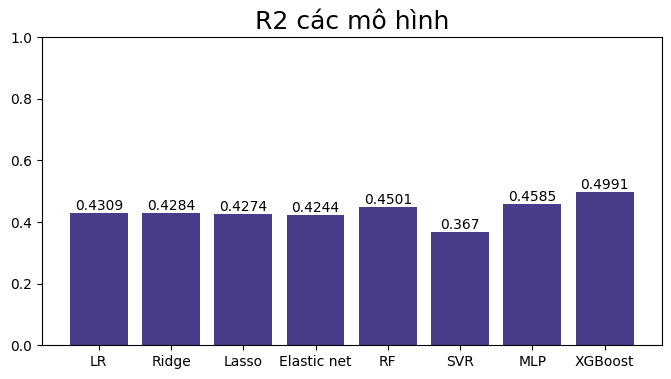

In [ ]:
score = {'LR': 0.4309, 'Ridge': 0.4284, 'Lasso':0.4274, 'Elastic net':0.4244, 'RF':0.4501, 'SVR':0.3670, 'MLP': 0.4585, 'XGBoost':0.4991}
# Vẽ boxplot để so sánh các mô hình dựa trên R2
# model_names = ['LR', 'Ridge', 'Lasso', 'Elastic net', 'RF', 'SVR', 'MLP', 'XGBoost']

fig,ax1 = plt.subplots(figsize=(8, 4))
ax1.bar(list(score.keys()), list(score.values()), color='darkslateblue')
for container in ax1.containers:
    ax1.bar_label(container)
ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.set_ylim(0,1)
ax1.set_title("R2 các mô hình", fontsize=18)
plt.savefig('r2.jpeg')
plt.show()

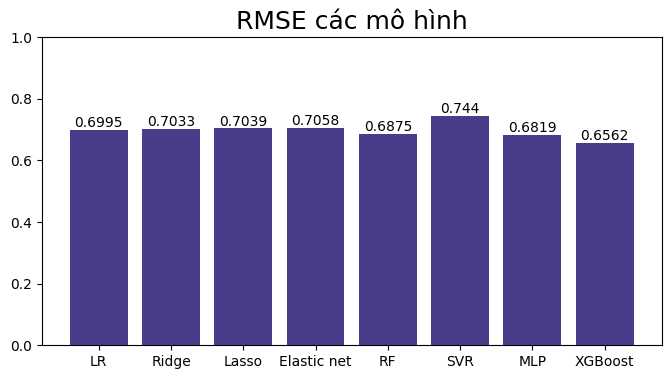

In [ ]:
score = {'LR': 0.6995, 'Ridge': 0.7033, 'Lasso':0.7039, 'Elastic net':0.7058, 'RF':0.6875, 'SVR':0.7440, 'MLP': 0.6819, 'XGBoost':0.6562}
# Vẽ boxplot để so sánh các mô hình dựa trên RMSE
# model_names = ['LR', 'Ridge', 'Lasso', 'Elastic net', 'RF', 'SVR', 'MLP', 'XGBoost']

fig,ax1 = plt.subplots(figsize=(8, 4))
ax1.bar(list(score.keys()), list(score.values()), color='darkslateblue')
for container in ax1.containers:
    ax1.bar_label(container)
ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.set_ylim(0,1)
ax1.set_title("RMSE các mô hình", fontsize=18)
plt.savefig('rmse.jpeg')
plt.show()

# Feature Selection for XgBoost

In [ ]:
# Define a custom transformer for feature selection
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, threshold='mean'):
        self.threshold = threshold
        self.selector = None

    def fit(self, X, y=None):
        # Use a basic model to determine feature importances
        model = XGBRegressor(n_jobs=-1)
        model.fit(X, y)
        self.selector = SelectFromModel(model, threshold=self.threshold, prefit=True)
        return self

    def transform(self, X):
        return self.selector.transform(X)

In [ ]:
# Define groups of variables
categorical_features = ['GIOI_TINH', 'MA_LYDO_VVIEN', 'MA_LOAI_KCB', 'regions', 'HI',
       'insurance', 'hang', 'tuyen', 'comorbidities',
        'loaiBienChung', 'nhomTuoi']
numerical_features = ['Tuổi', 'Số ngày điều trị']   
other_features = ['Ky_QT_adjust','checkComorbidities', 'soBienChung_cat', 'diemBienChung_cat']     # maintained columns

In [ ]:
# Define preprocessor
categorical_features = ['GIOI_TINH']
                        
label_enc_features = ['regions', 'HI',
       'insurance', 'hang', 'tuyen', 'comorbidities',
        'loaiBienChung', 'nhomTuoi']

numerical_features = ['Tuổi', 'Số ngày điều trị']  
other_features = ['Ky_QT_adjust','MA_LYDO_VVIEN', 'MA_LOAI_KCB', 'checkComorbidities', 'soBienChung_cat', 'diemBienChung_cat']     # maintained columns

def label_encode_column(column):
    le = LabelEncoder()
    return le.fit_transform(column)

# Function to apply LabelEncoder to each specified column
def label_encode_df(df, columns):
    for column in columns:
        df[column] = label_encode_column(df[column])
    return df

# Define preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('label', FunctionTransformer(lambda df: label_encode_df(df.copy(), label_enc_features), validate=False), label_enc_features),
        ('other', 'passthrough', other_features)
    ]
)
# Create the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    # ('feature_selection', FeatureSelector()),
    ('regressor', XGBRegressor(n_jobs=-1))
])

# Define the parameter grid
param_grid = {
    # 'feature_selection__threshold': ['mean', 'median', 0.01, 0, ],
    'regressor__n_estimators': [200],
    'regressor__max_depth': [6],
    # 'regressor__learning_rate': [0.01, 0.1],
    'regressor__subsample': [1.0]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='r2', verbose=1)
grid_search.fit(X_train, y_train)

# Evaluate the model
best_model = grid_search.best_estimator_

best_xgb = best_model.named_steps['regressor']
importances = best_xgb.feature_importances_

#
cat_feature_names = best_model.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features)

# Combine all feature names
feature_names = list(numerical_features) + list(cat_feature_names) +list(label_enc_features)+ list(other_features)


feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df= feature_importance_df.sort_values(by='Importance', ascending=False)
print("Feature importances:\n", feature_importance_df)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Feature importances:
                Feature  Importance
1     Số ngày điều trị    0.270262
14         MA_LOAI_KCB    0.244044
8                tuyen    0.189345
7                 hang    0.153446
4              regions    0.024365
10       loaiBienChung    0.021891
12        Ky_QT_adjust    0.019355
13       MA_LYDO_VVIEN    0.015785
9        comorbidities    0.014872
17   diemBienChung_cat    0.013827
16     soBienChung_cat    0.008099
6            insurance    0.008084
15  checkComorbidities    0.007497
0                 Tuổi    0.003321
5                   HI    0.003203
2          GIOI_TINH_1    0.002604
3          GIOI_TINH_2    0.000000
11            nhomTuoi    0.000000


In [ ]:
preprocessor_from_pipeline = best_model.named_steps['preprocessor']

# Transform data using the preprocessor
X_preprocessed = preprocessor_from_pipeline.transform(X)

# Convert the result to a DataFrame
X_preprocessed_df = pd.DataFrame(X_preprocessed, columns=feature_names)
X_preprocessed_df = X_preprocessed_df.astype('float')

Best threshold: 0.0


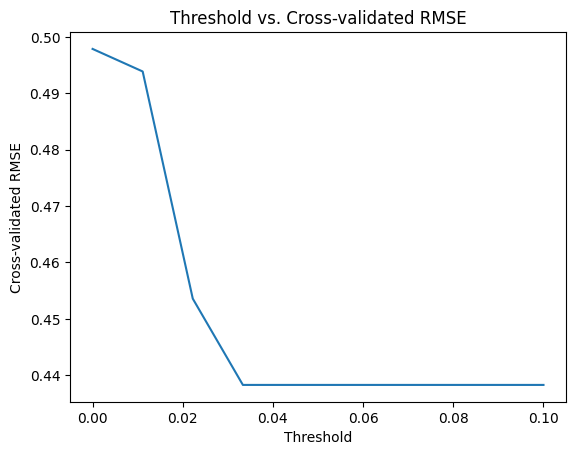

In [ ]:
metric = make_scorer(root_mean_squared_error)

# Function to evaluate model with a given threshold
def evaluate_threshold(threshold):
    selected_features = feature_importance_df[feature_importance_df['Importance'] >= threshold]['Feature'].tolist()
    # X_selected = df_sample_rm_outliers.drop('log(Tổng chi phí)', axis=1)[selected_features]

    X_selected = X_preprocessed_df[selected_features]
    X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
    # model.fit(X_train, y_train)
    model = XGBRegressor(n_estimators=200, max_depth=6, subsample=1.0, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    scores = r2_score(y_test, y_pred)
    return scores

# Try different thresholds and find the best one
thresholds = np.linspace(0, 0.1, 10)
scores = [evaluate_threshold(th) for th in thresholds]

# Find the best threshold
best_threshold = thresholds[np.argmax(scores)]
print(f"Best threshold: {best_threshold}")

# Plot scores vs. thresholds
plt.plot(thresholds, scores)
plt.xlabel('Threshold')
plt.ylabel('Cross-validated RMSE')
plt.title('Threshold vs. Cross-validated RMSE')
plt.show()

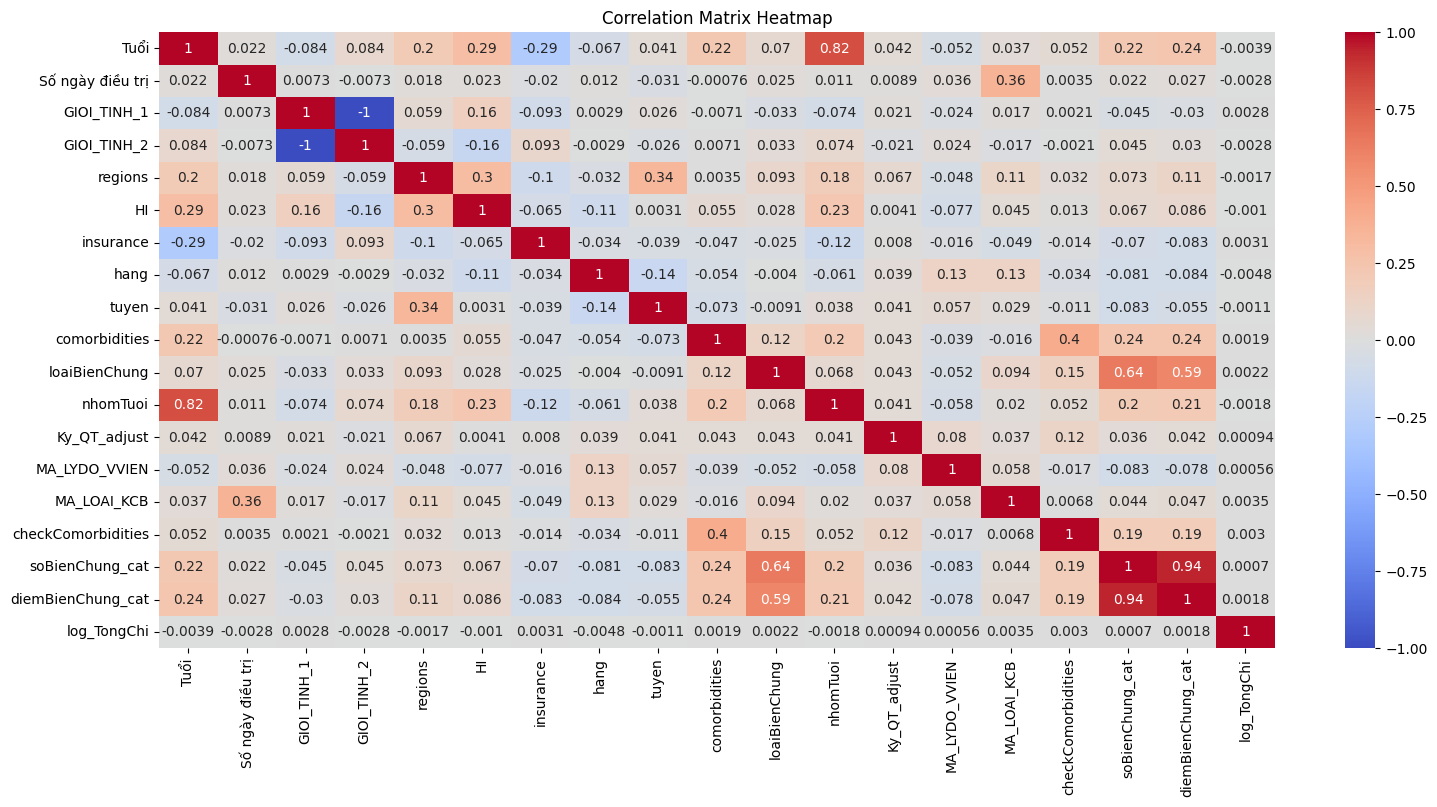

In [ ]:
corr_matrix=pd.concat([X_preprocessed_df,y], axis=1).corr()

# Visualize correlation matrix using a heatmap
plt.figure(figsize=(18, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix Heatmap')
plt.show()

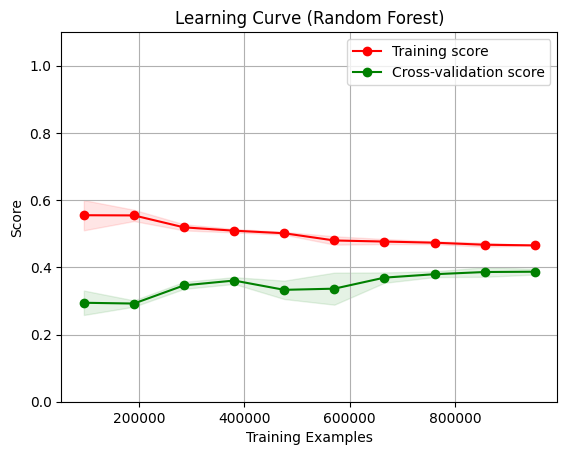

In [ ]:
model = XGBRegressor(n_estimators=100, random_state=42, max_depth=3, )

train_sizes, train_scores, test_scores = learning_curve(
    model, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10), random_state=42
)

# Calculate mean and standard deviation for training and test scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure()
plt.title("Learning Curve (Random Forest)")
plt.xlabel("Training Examples")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
plt.grid()

# Plot training and cross-validation score curves
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.legend(loc="best")
plt.show()

# Tuning Parameters

In [ ]:
# Create the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', FeatureSelector()),
    ('regressor', XGBRegressor(n_jobs=-1))
])

# Define the parameter grid
param_grid = {
    'feature_selection__threshold': ['mean', 'median', 0.01, 0, ],
    'regressor__n_estimators': [200],
    'regressor__max_depth': [6],
    # 'regressor__learning_rate': [0.01, 0.1],
    'regressor__subsample': [1.0]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='r2', verbose=1)
grid_search.fit(X_train, y_train)

# Evaluate the model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print(f'R2 Score: {r2_score(y_test, y_pred)}')
print(f'RMSE: {root_mean_squared_error(y_test, y_pred, squared=False)}')

Fitting 3 folds for each of 4 candidates, totalling 12 fits
R2 Score: 0.4993137418275788
MAE: 0.4967156222092549
RMSE: 0.6582269164362045


In [ ]:
for param, value in best_model.get_params().items():
    # print(f"{param}: {value}")
    print(param, value)
    print('--')

memory None
--
steps [('preprocessor', ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['Tuổi', 'Số ngày điều trị']),
                                ('cat', OneHotEncoder(handle_unknown='ignore'),
                                 ['GIOI_TINH', 'MA_LYDO_VVIEN', 'MA_LOAI_KCB',
                                  'regions', 'HI', 'insurance', 'hang', 'tuyen',
                                  'comorbidities', 'loaiBienChung',
                                  'nhomTuoi']),
                                ('other', 'passthrough',
                                 ['Ky_QT_adjust', 'checkComorbidities',
                                  'soBienChung_cat', 'diemBienChung_cat'])])), ('feature_selection', FeatureSelector(threshold='median')), ('regressor', XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
    

In [ ]:
scoring = {
    'r2': make_scorer(r2_score),
    'rmse': make_scorer(root_mean_squared_error)
}

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(max_depth=7))
])

# Perform cross-validation
pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred = pipeline.predict(X_test)


# Access the results
print("R2 scores:", r2_score(y_test, y_pred))
print("RMSE scores:", root_mean_squared_error(y_test, y_pred))

R2 scores: 0.5065839433119272
RMSE scores: 0.6530575034184534


# Model Evaluation

In [ ]:
y_pred = pipeline.predict(X_train)


# Access the results
print("R2 scores:", r2_score(y_train, y_pred))
print("RMSE scores:", root_mean_squared_error(y_train, y_pred))

R2 scores: 0.5025121727500674
RMSE scores: 0.654844785956202


In [ ]:
rd = np.random.randint(1, 100000, size=10)
pd.DataFrame(np.exp(y_pred[rd]), np.exp(y_train[rd]))

,0
log_TongChi,
710477.00,436071.84375
225890.00,379662.59375
261080.00,295502.25000
428204.00,430377.00000
283810.00,417662.71875
1019720.00,416152.25000
5106334.00,426405.15625
1230823.97,611284.93750
116736.00,655369.12500


In [ ]:
import pickle
file_name = 'pipeline.pkl'

# preprocessor = pipeline.named_steps['preprocessor']
# model = pipeline.named_steps['regressor']

with open(file_name, 'wb') as file:
    pickle.dump(pipeline, file)